In [1]:
!pip install kagglehub
import kagglehub
import os

print("Downloading dataset...")
path = kagglehub.dataset_download("emmarex/plantdisease")
print("Path to dataset files:", path)
directory_root = os.path.join(path, "PlantVillage")
print("Path to images:", directory_root)

Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease
Path to images: /kaggle/input/plantdisease/PlantVillage


In [2]:
import tensorflow as tf

# Define constants for the data pipeline
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create the main training dataset (80%)
print("Creating training dataset...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory_root,
    validation_split=0.2,  # Reserve 20% for validation and testing
    subset="training",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Create the temporary hold-out dataset (the 20%)
print("Creating validation/test dataset...")
temp_ds = tf.keras.utils.image_dataset_from_directory(
    directory_root,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Get the class names and count
class_names = train_ds.class_names
n_classes = len(class_names)
print(f"Found {n_classes} classes.")

# Split the 20% hold-out into 10% validation and 10% test
val_batches = tf.data.experimental.cardinality(temp_ds) // 2
val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

print("Optimizing data pipelines...")
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Data pipelines created successfully.")

Creating training dataset...
Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Creating validation/test dataset...
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Found 15 classes.
Optimizing data pipelines...
Data pipelines created successfully.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[INFO] STEP 1: Warming up the model head...
Epoch 1/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 86s 145ms/step - accuracy: 0.1235 - loss: 2.6968 - val_accuracy: 0.2090 - val_loss: 2.4435
Epoch 2/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 74s 143ms/step - accuracy: 0.1853 - loss: 2.4702 - val_accuracy: 0.2349 - val_loss: 2.3639
Epoch 3/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 74s 143ms/step - accuracy: 0.2109 - loss: 2.4022 - val_accuracy: 0.2646 - val_loss: 2.3054
Epoch 4/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 73s 142ms/step - accuracy: 0.2285 - loss: 2.3592 - val_accuracy: 0.3096 - val_loss: 2.2641
Epoch 5/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 73s 142ms/step - accuracy: 0.2373 - loss: 2.3263 - val_accuracy: 0.3018 - val_loss: 2.2169
Epoch 6/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 74s 142ms/step - accuracy: 0.2565 - loss: 2.2867 - val_accuracy: 0.3232 - val_loss: 2.1839
Epoch 7/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 74s 143ms/step - accuracy: 0.2760 - loss: 2.2601 - val_accuracy: 0.3394 - val_l

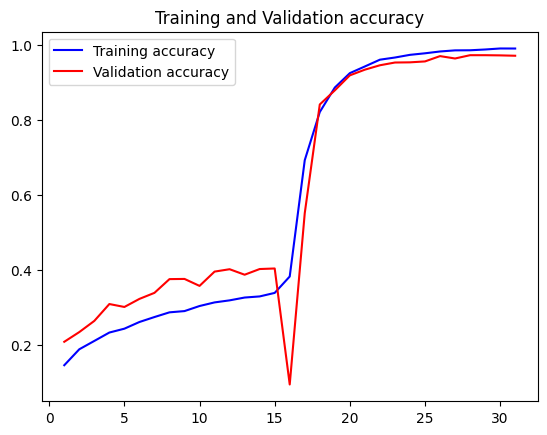

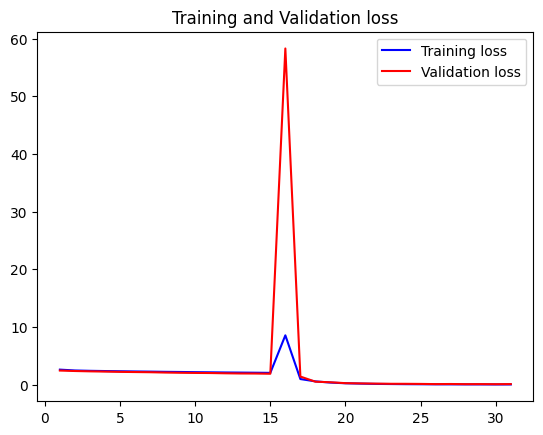

[INFO] Calculating model accuracy on test set
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9814 - loss: 0.0764
Test Accuracy: 98.124098777771
[INFO] Saving model...
Saving class names...


In [3]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from os import listdir

# --- Constants ---
EPOCHS = 30
INIT_LR = 1e-4
width = 224
height = 224
depth = 3
FINE_TUNE_AT_EPOCH = 15
FINE_TUNE_LR = INIT_LR / 10 # 1e-5

# --- Preprocessing Layer ---
data_preprocessing = Sequential(
  [
    Rescaling(1./255), # Normalization
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2),
  ],
  name="data_preprocessing",
)

# --- Build Model Function ---
def build_model(architecture_name, n_classes, input_shape):
    """Builds ResNet50 or EfficientNet model with Transfer Learning."""

    if architecture_name == 'ResNet50':
        base_model = ResNet50(weights="imagenet", include_top=False,
                              input_shape=input_shape)
    elif architecture_name == 'EfficientNet':
        base_model = EfficientNetB0(weights="imagenet", include_top=False,
                                      input_shape=input_shape)
    else:
        raise ValueError("Invalid architecture name")

    # Freeze the base layers
    base_model.trainable = False

    x = data_preprocessing(base_model.input)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

# --- Model Creation ---
inputShape = (height, width, depth) # Run one at a time
model, base_model = build_model('ResNet50', n_classes, inputShape)
# model, base_model = build_model('EfficientNet', n_classes, inputShape)

# --- ================== STEP 1: WARM-UP TRAINING ================== ---
print("[INFO] STEP 1: Warming up the model head...")

opt = Adam(learning_rate=INIT_LR)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train for the first 15 epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_TUNE_AT_EPOCH,
    verbose=1
)

# --- ================== STEP 2: FINE-TUNE TRAINING ================== ---
print("\n[INFO] STEP 2: Unfreezing and fine-tuning the model...")

# Unfreeze the base model
base_model.trainable = True

opt_fine_tune = Adam(learning_rate=FINE_TUNE_LR)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt_fine_tune, metrics=["accuracy"])

# Continue training from where we left off
# The model will train for (EPOCHS - FINE_TUNE_AT_EPOCH) more epochs
history_fine_tune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS, # Total epochs to run to
    initial_epoch=history.epoch[-1], # Start from the last epoch number
    verbose=1
)

# --- ================== ANALYSIS AND SAVING ================== ---

# Combine the history objects for plotting
acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
loss = history.history['loss'] + history_fine_tune.history['loss']
val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting
print("Plotting training history...")
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Evaluate
print("[INFO] Calculating model accuracy on test set")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1]*100}")

# Save Model
print("[INFO] Saving model...")
model.save('cnn_model.keras')

print("Saving class names...")
with open('label_transform.pkl', 'wb') as f:
    pickle.dump(class_names, f)

[INFO] Loading saved model...
[INFO] Evaluating model on the test dataset...
Evaluation complete.

--- Classification Report ---
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.99      0.98        99
                     Pepper__bell___healthy       1.00      1.00      1.00       154
                      Potato___Early_blight       0.96      1.00      0.98        98
                       Potato___Late_blight       1.00      1.00      1.00        89
                           Potato___healthy       1.00      1.00      1.00        15
                      Tomato_Bacterial_spot       0.97      1.00      0.98       222
                        Tomato_Early_blight       1.00      0.98      0.99       101
                         Tomato_Late_blight       0.99      0.99      0.99       198
                           Tomato_Leaf_Mold       1.00      0.99      0.99        89
                  To

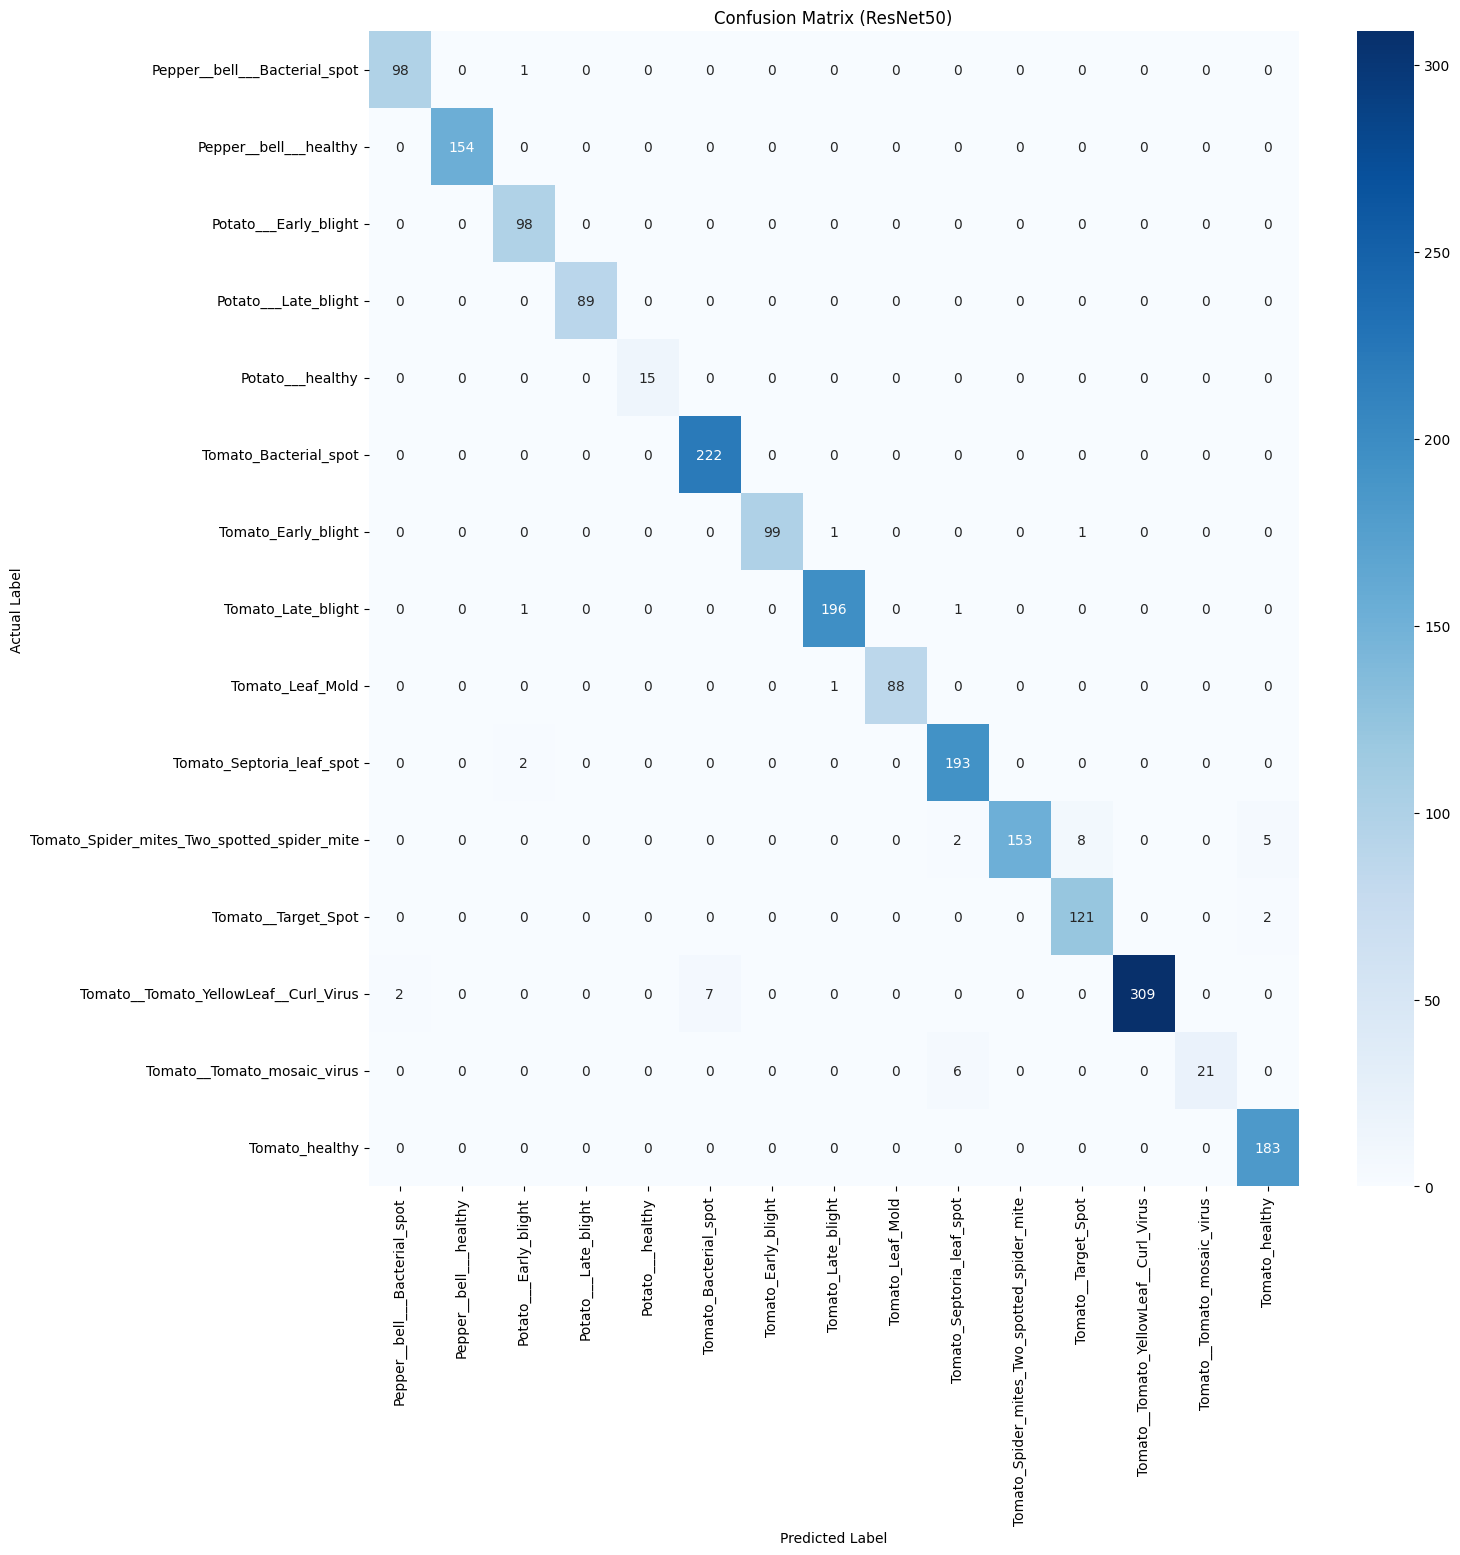

In [4]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# --- 1. Get True Labels and Predictions ---

print("[INFO] Loading saved model...")

model = tf.keras.models.load_model('cnn_model.keras')

print("[INFO] Evaluating model on the test dataset...")

y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

print("Evaluation complete.")

# --- 2. Print Classification Report ---

print("\n--- Classification Report ---")

print(classification_report(y_true, y_pred, target_names=class_names))

print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix (ResNet50)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()